In [1]:
!pip install fairlearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from fairlearn.metrics import selection_rate
import kagglehub
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import DataCollatorWithPadding
from tqdm import tqdm
from IPython.display import FileLink
from scipy.stats import mode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.3 MB/s eta 0:00:0000:01


2025-05-31 18:07:18.157905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748714838.364420      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748714838.427609      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
test_df = pd.read_csv("/kaggle/input/amazon-reviews-multi/test.csv")

In [4]:
def keep_only_language(df, language):
    """
    Keeps only rows where the 'language' column matches the specified language.
    """
    return df[df['language'] == language].reset_index(drop=True)

In [5]:
def clean_and_check_nulls(df, name="Dataset"):
    original_len = len(df)
    df = df.dropna(subset=['review_title'])
    dropped = original_len - len(df)
    print(f"{name}: Dropped {dropped} rows with null 'review_title'.")
    
    remaining_nulls = df.isnull().sum()
    if remaining_nulls.sum() == 0:
        print(f"{name}: No remaining nulls.")
    else:
        print(f"{name}: Remaining null values:\n{remaining_nulls[remaining_nulls > 0]}")
    
    return df

In [6]:
test_df = clean_and_check_nulls(test_df, "Test Set")

Test Set: Dropped 1 rows with null 'review_title'.
Test Set: No remaining nulls.


In [7]:
def process_dataframe(dataframe):
    dataframe.drop(columns=["Unnamed: 0","review_id", "product_id", "reviewer_id"], axis = 1, inplace = True)

    dataframe = dataframe[dataframe['language'].isin(['de', 'es', 'en'])]
    dataframe = dataframe[dataframe['stars'] != 3]
    dataframe['sentiment'] = dataframe['stars'].apply(lambda x: 0 if x in [1, 2] else 1)

    sentiment_counts = dataframe.groupby(['language', 'sentiment']).size().unstack(fill_value=0)
    
    sentiment_counts.plot(kind='bar', stacked=False)
    plt.title('Sentiment Distribution per Language')
    plt.xlabel('Language')
    plt.ylabel('Number of Reviews')
    plt.legend(title='Sentiment (0=Negative, 1=Positive)')
    plt.tight_layout()
    plt.show()

    dataframe.drop(columns=["stars"], axis = 1, inplace = True)

    return dataframe
    

/nProcessing TEST dataset


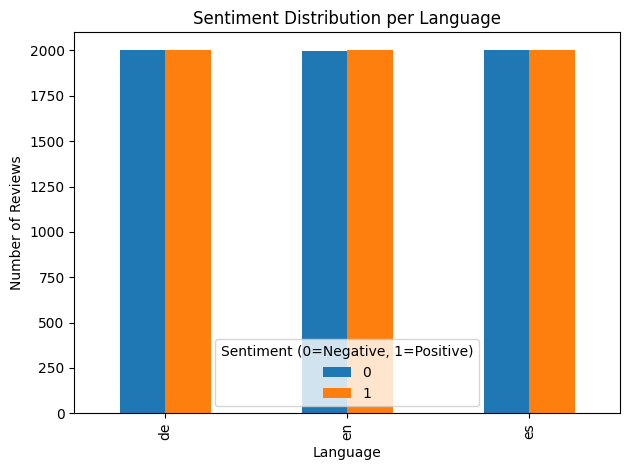

In [8]:
print("/nProcessing TEST dataset")
test_df = process_dataframe(test_df)

In [9]:
def tokenize_function_test(example):
    tokenized = tokenizer(example['text'], truncation=True, padding="max_length", max_length=512)
    return tokenized

In [10]:
def format_convert_and_show(df, name="Dataset", num_samples=2, lang_code=None):
    df = df.copy()

    prompt_templates = {
        'en': "CATEGORY: {category}\nTITLE: {title}\REVIEW TEXT: {body}",
    }

    def format_row(row):
        lang = lang_code if lang_code else row['language']
        template = prompt_templates.get(lang, prompt_templates['en'])
        return template.format(
            category=row['product_category'],
            title=row['review_title'],
            body=row['review_body']
        )

    df['text'] = df.apply(format_row, axis=1)

    df = df.drop(columns=['review_title', 'review_body', 'product_category'], axis=1)
    return df

In [11]:
lang = "en"
test_lang_df = keep_only_language(test_df, lang)
test_lang_df = format_convert_and_show(test_lang_df, name=f"Test {lang}", num_samples=1)

In [12]:
model_specs = [
    ("bert", "bert-base-multilingual-cased", "/kaggle/input/bert_base_model_en/transformers/default/1/best_model_en.pt"),
    ("distilbert", "distilbert-base-multilingual-cased", "/kaggle/input/distilbert_best_model_en/transformers/default/1/best_model_en (1).pt"),
    ("xlm_roberta", "xlm-roberta-base", "/kaggle/input/xml_best_model_en/transformers/default/1/best_model_en.pt"),
]
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def compute_fairness_metrics(y_true, y_pred, group_name=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    epsilon = 1e-10

    statistical_parity = (tp + fp) / (tp + fp + tn + fn + epsilon)
    equality_of_opportunity = tp / (tp + fn + epsilon)
    calibration_pos = tp / (tp + fp + epsilon)
    calibration_neg = tn / (tn + fn + epsilon)
    conditional_use_error_pos = fp / (tp + fp + epsilon)
    conditional_use_error_neg = fn / (tn + fn + epsilon)
    treatment_equality_fp_fn = fp / (fn + epsilon) if fn != 0 else 0
    treatment_equality_fn_fp = fn / (fp + epsilon) if fp != 0 else f0
    
    print(f"\nFairness Metrics ({group_name})")
    print(f"Statistical Parity             : {statistical_parity:.4f}")
    print(f"Equality of Opportunity        : {equality_of_opportunity:.4f}")
    print(f"Calibration (Pos)              : {calibration_pos:.4f}")
    print(f"Calibration (Neg)              : {calibration_neg:.4f}")
    print(f"Conditional Use Error (P)      : {conditional_use_error_pos:.4f}")
    print(f"Conditional Use Error (N)      : {conditional_use_error_neg:.4f}")
    print(f"Treatment Equality (FP/FN)     : {treatment_equality_fp_fn:.4f}")
    print(f"Treatment Equality (FN/FP)     : {treatment_equality_fn_fp:.4f}")

    return {
        "statistical_parity": statistical_parity,
        "equality_of_opportunity": equality_of_opportunity,
        "calibration_pos": calibration_pos,
        "calibration_neg": calibration_neg,
        "conditional_use_error_pos": conditional_use_error_pos,
        "conditional_use_error_neg": conditional_use_error_neg,
        "treatment_equality_fp_fn": treatment_equality_fp_fn,
        "treatment_equality_fn_fp": treatment_equality_fn_fp
    }

In [14]:
all_preds = []
true_labels = None
model_preds = {} 
results_table = []
english_only_preds = []

for model_id, model_name, model_path in model_specs:
    print("\n-------------------------")
    print(f"\nEvaluating metrics for model: {model_id}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)


    test_dataset = Dataset.from_pandas(test_lang_df.reset_index(drop=True))
    test_dataset = test_dataset.map(tokenize_function_test, batched=True)
    test_dataset = test_dataset.rename_column("sentiment", "labels")
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    preds = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {model_id}", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=-1)
            preds.extend(pred.cpu().numpy())

            if true_labels is None:
                labels.extend(batch['labels'].numpy())

    all_preds.append(np.array(preds))
    model_preds[model_id] = np.array(preds) 

    if model_id in ["bert", "distilbert", "xlm_roberta"]:
        english_only_preds.append(np.array(preds))

    if true_labels is None:
        true_labels = np.array(labels)
        sensitive_features = test_lang_df["language"].values


-------------------------

Evaluating metrics for model: bert


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                                  


-------------------------

Evaluating metrics for model: distilbert


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                                        


-------------------------

Evaluating metrics for model: xlm_roberta


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Ensemble Model Performance
Accuracy: 0.8147
F1 Score : 0.8082


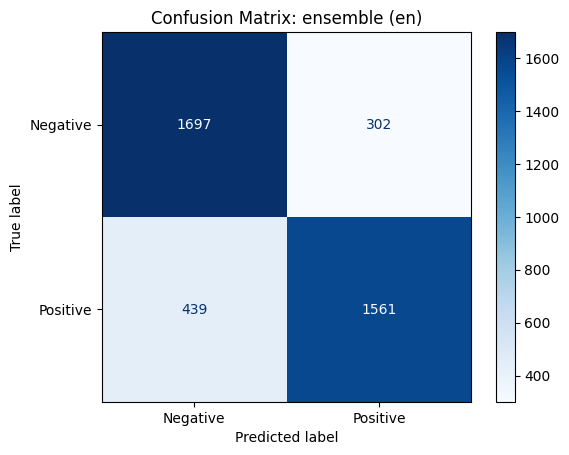


Accuracy: 0.8147
F1 Score: 0.8082
Selection Rate: 0.4659

Fairness Metrics (ensemble (en))
Statistical Parity             : 0.4659
Equality of Opportunity        : 0.7805
Calibration (Pos)              : 0.8379
Calibration (Neg)              : 0.7945
Conditional Use Error (P)      : 0.1621
Conditional Use Error (N)      : 0.2055
Treatment Equality (FP/FN)     : 0.6879
Treatment Equality (FN/FP)     : 1.4536


In [15]:
stacked_preds = np.stack(english_only_preds, axis=0)
majority_preds, _ = mode(stacked_preds, axis=0)
majority_preds = majority_preds.squeeze()
model_preds["ensemble"] = majority_preds
results_tabel = []
lang_code = 'en'
model_id = 'ensemble'

acc = accuracy_score(true_labels, majority_preds)
f1 = f1_score(true_labels, majority_preds)

print(f"\nEnsemble Model Performance")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score : {f1:.4f}")

y_true, y_pred = true_labels, majority_preds

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix: {model_id} ({lang_code or 'all'})")
plt.show()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
sel_rate = selection_rate(y_true, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Selection Rate: {sel_rate:.4f}")

fairness_metrics = compute_fairness_metrics(y_true, y_pred, group_name=f"{model_id} ({lang_code or 'all'})")

entry = {
    "model": model_id,
    "lang": lang_code or "all",
    "accuracy": acc,
    "f1_score": f1,
    "selection_rate": sel_rate,
    **fairness_metrics
}
results_table.append(entry)